In [1]:
import os
import six.moves.cPickle as pickle
import gzip


def load_data(dataset):
    ''' Loads the dataset

    :type dataset: string
    :param dataset: the path to the dataset (here MNIST)
    '''

    #############
    # LOAD DATA #
    #############

    # Download the MNIST dataset if it is not present
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join(
            os.path.split(__file__)[0],
            #"..",
            #"data",
            dataset
        )
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        )
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)

    print('... loading data')

    # Load the dataset
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # train_set, valid_set, test_set format: tuple(input, target)
    # input is a numpy.ndarray of 2 dimensions (a matrix)
    # where each row corresponds to an example. target is a
    # numpy.ndarray of 1 dimension (vector) that has the same length as
    # the number of rows in the input. It should give the target
    # to the example with the same index in the input.
    print('dataset is loaded')

In [2]:
import numpy as np
# load the MNIST dataset
dataset = 'mnist.pkl.gz'
number_train_samples = 20000 #Max = 50 000


with gzip.open(dataset, 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)

train_set_x, train_set_y = train_set
train_set_x, train_set_y = np.array(train_set_x), np.array(train_set_y)
train_set_x = train_set_x[0:number_train_samples,:]
valid_set_x, valid_set_y = valid_set
valid_set_x, valid_set_y  = np.array(valid_set_x), np.array(valid_set_y)
test_set_x, test_set_y = test_set
test_set_x, test_set_y = np.array(test_set_x), np.array(test_set_y)

#train_set_x = (train_set_x-127.5)/127.5
train_set_x.shape = (number_train_samples,28,28,1)
#valid_set_x = (valid_set_x-127.5)/127.5
valid_set_x.shape = (10000,28,28,1)
#test_set_x = (test_set_x-127.5)/127.5
test_set_x.shape = (10000,28,28,1)

In [3]:
###Neural network models
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

latent_size = 100

Using TensorFlow backend.


In [4]:
def build_generator(latent_size):
    # we will map z, where z is a latent vector, to image space (..., 28, 28, 1)
    cnn = Sequential()

    cnn.add(Dense(3 * 3 * 384, input_dim=latent_size, activation='relu'))
    cnn.add(Reshape((3, 3, 384)))

    # upsample to (7, 7, ...)
    cnn.add(Conv2DTranspose(192, 5, strides=1, padding='valid',
                            activation='relu',
                            kernel_initializer='glorot_normal'))

    # upsample to (14, 14, ...)
    cnn.add(Conv2DTranspose(96, 5, strides=2, padding='same',
                            activation='relu',
                            kernel_initializer='glorot_normal'))

    # upsample to (28, 28, ...)
    cnn.add(Conv2DTranspose(1, 5, strides=2, padding='same',
                            activation='tanh',
                            kernel_initializer='glorot_normal'))

    # this is the z space commonly referred to in GAN papers
    latent = Input(shape=(latent_size, ))

    # hadamard product between z-space and a class conditional embedding
    fake_image = cnn(latent)

    return Model(latent, fake_image)


gen = build_generator(latent_size)
gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2655745   
Total params: 2,655,745
Trainable params: 2,655,745
Non-trainable params: 0
_________________________________________________________________


In [5]:
def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2,
                   input_shape=(28, 28, 1)))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(28, 28, 1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)

    return Model(image, fake)

discrim = build_discriminator()
discrim.compile(loss='binary_crossentropy', optimizer=Adam())
discrim.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 12544)             387840    
_________________________________________________________________
generation (Dense)           (None, 1)                 12545     
Total params: 400,385
Trainable params: 400,385
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Combined model

inputGAN = Input(shape=[latent_size])
fake_img = gen(inputGAN)
discrim.trainable = False
res = discrim(fake_img)
GAN = Model(inputGAN,res)
GAN.compile(loss='binary_crossentropy', optimizer=Adam())

In [7]:
from sklearn.utils import shuffle

def discriminator_training(generator, discriminator, batch_size, epochs, latent_size):
    
    for i in range(0, epochs):
        #Generate fake images with generator
        noise_vec = np.random.uniform(-1, 1, (number_train_samples, latent_size))
        fake_images = generator.predict(noise_vec)
        y_fake = np.full((number_train_samples), 0.05)

        #Concatenate fake and real images
        X = np.concatenate([train_set_x,fake_images])
        y_true = np.full((number_train_samples),0.95)
        Y = np.concatenate([y_true,y_fake])
        
        X,Y = shuffle(X,Y)
        discriminator.fit(X,Y, batch_size = batch_size)
        
def generator_training(GAN, generator, discriminator, batch_size, epochs, latent_size):
    
    for i in range(0, epochs):
        noise_vec = np.random.uniform(-1, 1, (2*number_train_samples, latent_size))
        #We want the generated images to be predicted as real images
        label_y = np.full((2*number_train_samples), 0.95)
        GAN.fit(noise_vec,label_y, batch_size = batch_size)  

In [17]:
import matplotlib.pyplot as plt

def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(0,3):
                new_img.append(img[i][j])
    new_img = np.array(new_img, dtype=float).reshape(img.shape[0], img.shape[1], 3)
    return new_img

def plot_img(img):
    print(img.shape)
    print("Image with confidence accorded by discriminator : ")
    print(discrim.predict(img))
    img = img*255
    img = np.array(img, dtype=int)
    img.shape = (28,28)
    img = grey2rgb(img)
    plt.imshow(img)
    plt.show()
    
def plot_generated_real_img():
    noise_vec = np.random.uniform(-1, 1, (1, latent_size))
    img = gen.predict(noise_vec)
    plot_img(img)

    img = train_set_x[15]
    img.shape = (1,28,28,1)
    plot_img(img)

Epoch 1/1
40000/40000 [==============================] - 180s - loss: 0.2064   
[[-0.50526821 -0.97077993 -0.28004306 -0.9543282   0.37866251  0.92187888
  -0.58356912 -0.20612829 -0.07716877  0.87977317  0.30749247 -0.08954145
   0.38326947 -0.02827706  0.54687287 -0.40330917  0.60650242  0.80893607
   0.68063839 -0.74042495 -0.6251326  -0.71738547 -0.16589197 -0.10763225
   0.92565188  0.03846511  0.21813207  0.01895601  0.91804834  0.83336148
  -0.24066051 -0.27884857 -0.2636794   0.13507723  0.5105299  -0.6402483
   0.35432986  0.88869778 -0.85800734  0.74502585 -0.84148331  0.69765447
  -0.57769696 -0.19738866  0.28150518  0.62856177 -0.33645372 -0.9852643
  -0.84493981 -0.81960276  0.19458621  0.03868954 -0.10038926 -0.31883262
  -0.22904314  0.98935397 -0.07409115 -0.22948736 -0.61213471  0.66043888
   0.53798124  0.85168234 -0.65372751  0.45956765 -0.36410067 -0.04785253
   0.6989397   0.73243402 -0.84740486  0.94722955  0.77489543 -0.17242783
   0.9976409   0.84374476 -0.93956

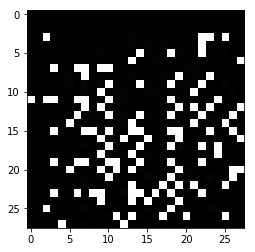

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.91059136]]


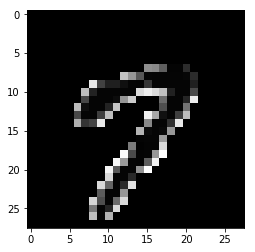

Epoch 1/1
40000/40000 [==============================] - 585s - loss: 0.2061   
[[ 0.49219879  0.95343134 -0.82122641  0.60277032 -0.12474138  0.85763445
  -0.04338677  0.63513104 -0.6683428  -0.70723784 -0.31208132  0.55649715
   0.88538564  0.70768596  0.13295384  0.52601134 -0.54158974 -0.74039443
   0.9791672  -0.92527699 -0.90682543  0.34936661 -0.30039376  0.85133164
  -0.0026378   0.62658204 -0.44967792  0.40558576 -0.68463128  0.1924459
  -0.62239245 -0.39914666 -0.82881067 -0.09167463  0.01334953  0.14442373
   0.29988778 -0.67671622 -0.93934498  0.70574267 -0.65869163  0.40553109
  -0.57915578 -0.68324365 -0.22238186 -0.99460365  0.01416829 -0.46182425
  -0.50298584 -0.12211258  0.3193439  -0.63142449 -0.69263781  0.6645637
  -0.95957607 -0.3291201   0.21706994 -0.73260502 -0.65172273  0.12645144
  -0.49614729  0.5069775   0.21766077  0.51997267  0.43805571  0.45465424
   0.7148682   0.91073026  0.73266384  0.23329871 -0.08539433 -0.44186003
   0.53468298  0.14152507  0.91525

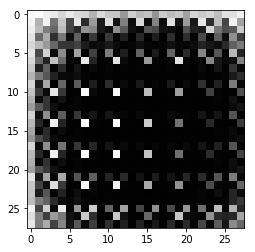

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.91059136]]


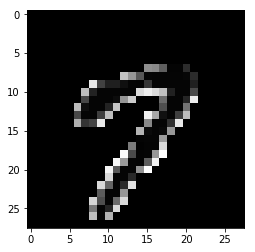

Epoch 1/1
40000/40000 [==============================] - 175s - loss: 0.2044   
[[-0.89486954 -0.83396685 -0.40704588 -0.50202232 -0.48275321 -0.0844365
   0.38624092  0.61498149 -0.81082909 -0.15939342  0.41975697 -0.29413668
   0.14235007  0.18460927  0.8628358   0.8631674   0.02161968  0.77759987
   0.58352773 -0.13724628 -0.05553256  0.77317727  0.74963476  0.28521822
  -0.19423521  0.40512433 -0.07200586  0.02764264  0.07350173  0.71548669
  -0.40549351  0.36238862  0.46942869 -0.16587548  0.95236506  0.59432908
   0.74350149 -0.56620549 -0.84131088 -0.22251542 -0.74001471 -0.91032251
   0.8031985  -0.07697798 -0.4302462   0.9769228   0.33676395 -0.38269932
  -0.30909255  0.65591812 -0.12230984  0.29090893 -0.12715806 -0.51598132
   0.59914547  0.64888337 -0.44181727  0.24287905  0.68057163 -0.21563769
   0.79710326  0.46690686 -0.16758912 -0.398431   -0.98232361 -0.6469243
   0.44565394 -0.40276101  0.59611228 -0.02582586 -0.99440893  0.46784825
   0.28662734  0.5648269  -0.10088

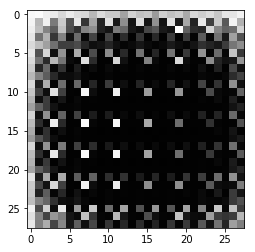

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94752175]]


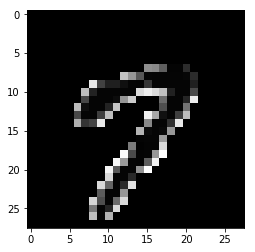

Epoch 1/1
40000/40000 [==============================] - 516s - loss: 0.2138   
[[-0.4459381  -0.35268511  0.95433715 -0.15714136 -0.8434374  -0.04802735
  -0.01462928 -0.49801295 -0.0993713  -0.25186958  0.41532749 -0.30403121
   0.45302511  0.87507864  0.37957916  0.67065004  0.14481488 -0.35383253
   0.19076235  0.41609675  0.32064766  0.45643013 -0.9588923  -0.0446585
  -0.93636669  0.68048534  0.29425832 -0.90467599  0.08377927 -0.6264363
  -0.27986642 -0.22556023  0.57804513  0.50200924 -0.64745919  0.23367759
   0.95282508  0.5984153  -0.43036131  0.35193974 -0.52793115 -0.41840878
   0.45168323 -0.45140661 -0.53024318 -0.34126335 -0.89945987  0.54297993
  -0.6152887   0.42229844  0.23736053  0.44427725 -0.67412835  0.40108664
   0.35835936 -0.36084457  0.54875277  0.31473569 -0.02554583 -0.63981525
  -0.67187405 -0.61008059 -0.19547388  0.13209921 -0.64752715  0.96728346
   0.01384648  0.71635068  0.99015435  0.16711461 -0.4684754  -0.70189602
   0.15986259 -0.29082814  0.63638

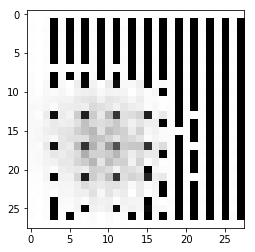

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94752175]]


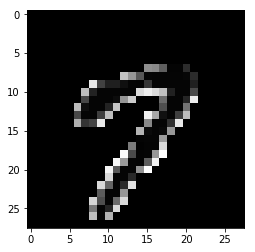

In [9]:
#Pre-training of the discriminator
#discriminator_training(gen,discrim,batch_size=64,epochs=1,latent_size=latent_size)

#Alternative training of the GAN
epochs = 5
k = 1   #discriminator trained k times, then generator trained once

for i in range(0,epochs):
    discriminator_training(gen,discrim,batch_size=64,epochs=k,latent_size=latent_size)
    plot_generated_real_img()
    
    generator_training(GAN,gen,discrim,batch_size=64,epochs=1,latent_size=latent_size)
    plot_generated_real_img()


Epoch 1/1
40000/40000 [==============================] - 160s - loss: 0.2068   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04475375]]


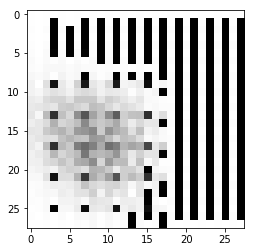

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94021672]]


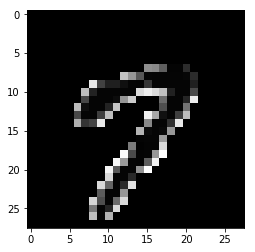

Epoch 1/1
40000/40000 [==============================] - 515s - loss: 0.2139   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94503415]]


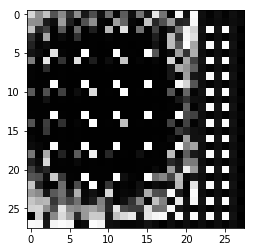

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94021672]]


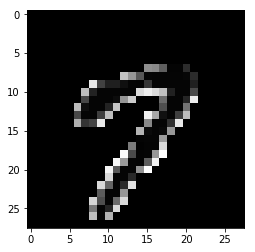

Epoch 1/1
40000/40000 [==============================] - 165s - loss: 0.2054   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04845797]]


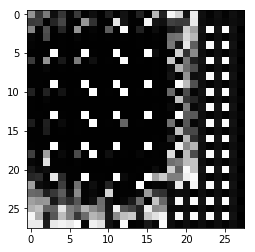

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95069486]]


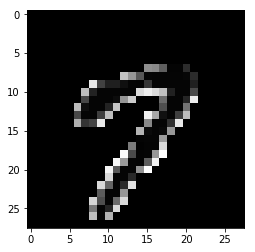

Epoch 1/1
40000/40000 [==============================] - 513s - loss: 0.2176   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93820781]]


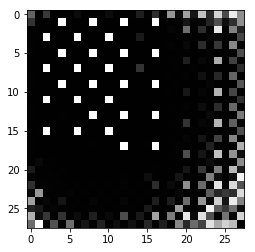

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95069486]]


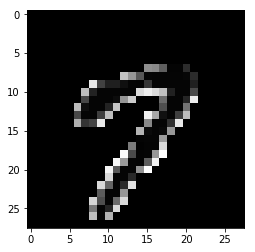

Epoch 1/1
40000/40000 [==============================] - 151s - loss: 0.5086   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  4.54958229e-19]]


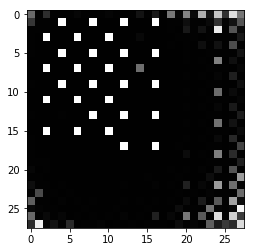

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95245379]]


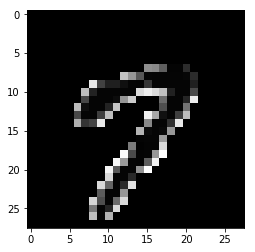

Epoch 1/1
40000/40000 [==============================] - 500s - loss: 15.3122   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  4.14299536e-19]]


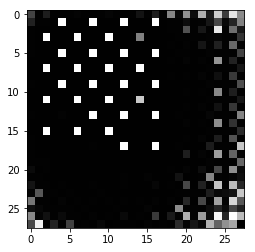

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95245379]]


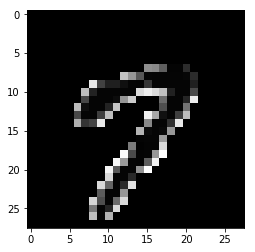

Epoch 1/1
40000/40000 [==============================] - 170s - loss: 0.5025   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  1.57288326e-13]]


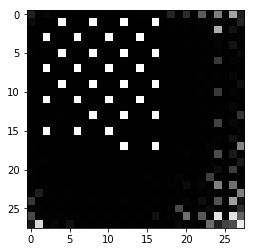

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9526872]]


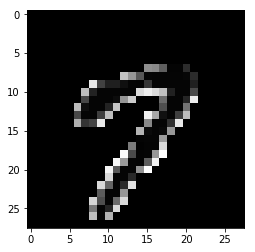

Epoch 1/1
40000/40000 [==============================] - 504s - loss: 3.0864   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.96248466]]


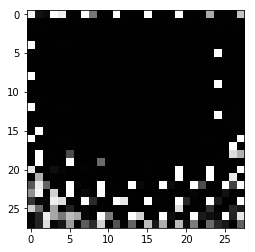

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9526872]]


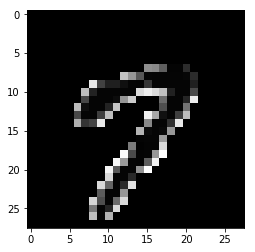

Epoch 1/1
40000/40000 [==============================] - 161s - loss: 0.5124   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  2.58976893e-15]]


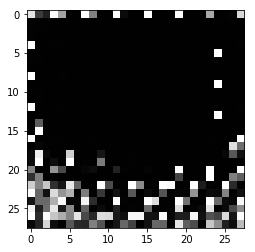

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94858289]]


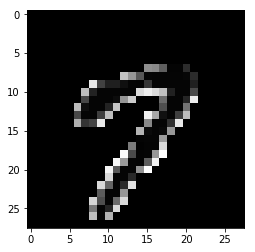

Epoch 1/1
40000/40000 [==============================] - 498s - loss: 15.3122   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  4.17632602e-15]]


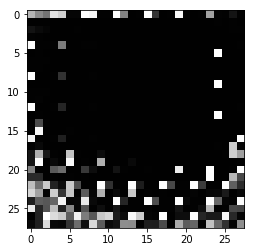

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94858289]]


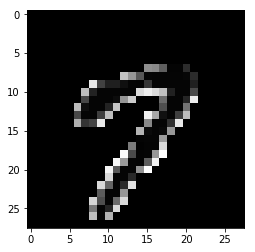

In [18]:
epochs = 5
k = 1   #discriminator trained k times, then generator trained once

for i in range(0,epochs):
    discriminator_training(gen,discrim,batch_size=64,epochs=k,latent_size=latent_size)
    plot_generated_real_img()
    
    generator_training(GAN,gen,discrim,batch_size=64,epochs=1,latent_size=latent_size)
    plot_generated_real_img()

Epoch 1/1
40000/40000 [==============================] - 155s - loss: 0.5025   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  1.15593760e-13]]


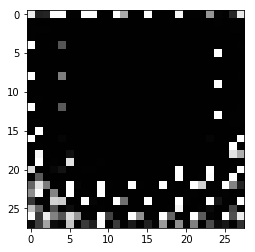

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94914448]]


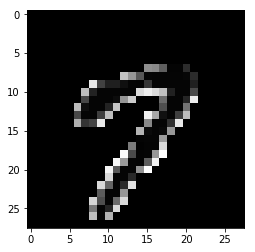

Epoch 1/1
40000/40000 [==============================] - 514s - loss: 6.5290   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.97365314]]


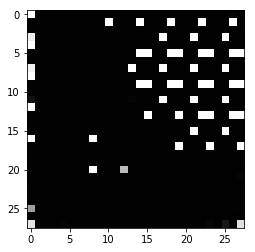

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94914448]]


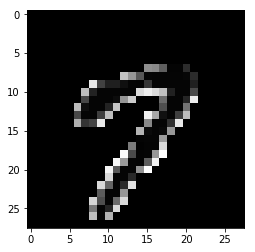

Epoch 1/1
40000/40000 [==============================] - 156s - loss: 0.5087   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  1.04351591e-21]]


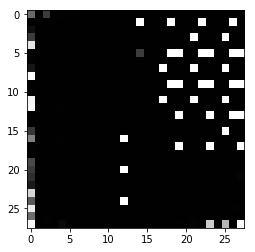

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94969755]]


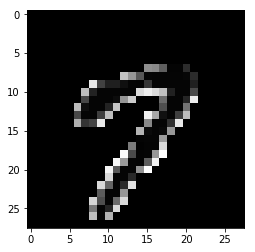

Epoch 1/1
40000/40000 [==============================] - 529s - loss: 15.3122   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  5.20563222e-17]]


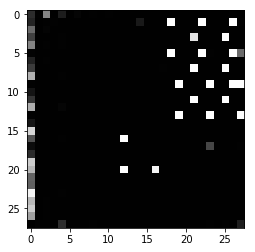

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94969755]]


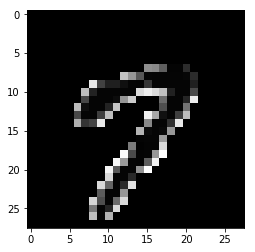

Epoch 1/1
40000/40000 [==============================] - 163s - loss: 0.5027   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  9.96136072e-15]]


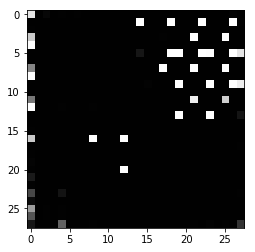

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94907284]]


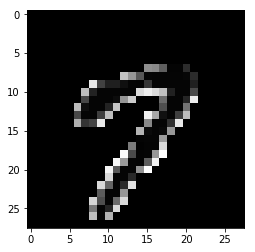

Epoch 1/1
40000/40000 [==============================] - 504s - loss: 6.6773   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.98827839]]


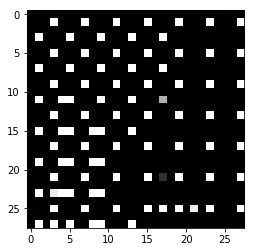

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94907284]]


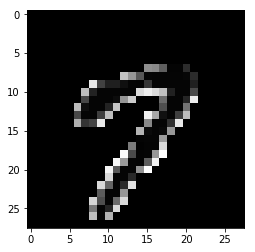

Epoch 1/1
40000/40000 [==============================] - 180s - loss: 0.5104   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  2.38733632e-15]]


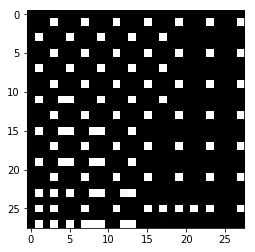

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9541769]]


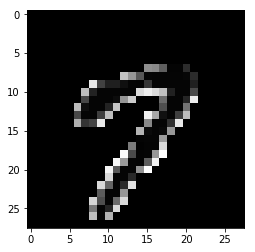

Epoch 1/1
40000/40000 [==============================] - 503s - loss: 15.3122   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  4.28187081e-14]]


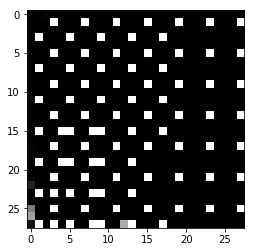

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9541769]]


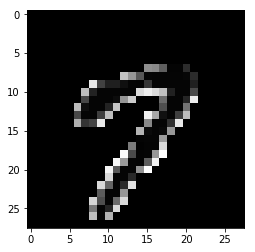

Epoch 1/1
40000/40000 [==============================] - 164s - loss: 0.5060   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  3.87895219e-28]]


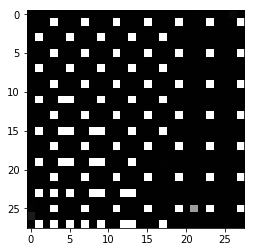

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94503075]]


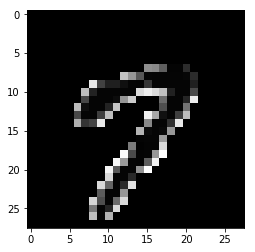

Epoch 1/1
40000/40000 [==============================] - 489s - loss: 15.3122   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  5.48204403e-28]]


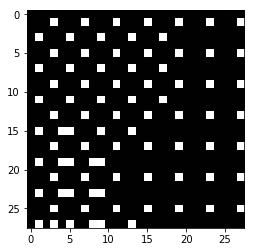

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94503075]]


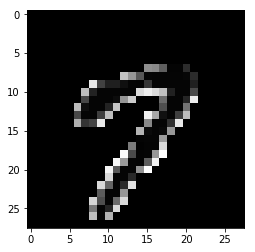

In [19]:
epochs = 1
k = 1   #discriminator trained k times, then generator trained once

for i in range(0,epochs):
    discriminator_training(gen,discrim,batch_size=64,epochs=k,latent_size=latent_size)
    plot_generated_real_img()
    
    generator_training(GAN,gen,discrim,batch_size=64,epochs=1,latent_size=latent_size)
    plot_generated_real_img()

Epoch 1/1
40000/40000 [==============================] - 155s - loss: 0.5029   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  8.13687148e-21]]


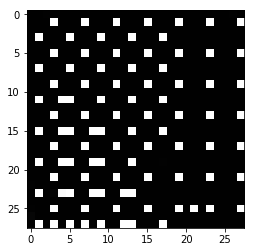

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94589984]]


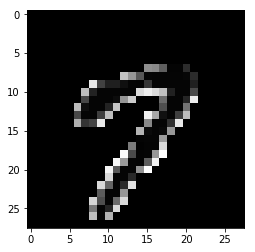

Epoch 1/1
40000/40000 [==============================] - 495s - loss: 15.3122   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  1.05917388e-19]]


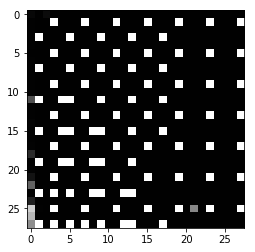

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94589984]]


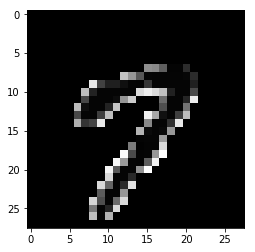

In [21]:
epochs = 1
k = 1   #discriminator trained k times, then generator trained once

for i in range(0,epochs):
    discriminator_training(gen,discrim,batch_size=64,epochs=k,latent_size=latent_size)
    plot_generated_real_img()
    
    generator_training(GAN,gen,discrim,batch_size=64,epochs=1,latent_size=latent_size)
    plot_generated_real_img()

Epoch 1/1
40000/40000 [==============================] - 162s - loss: 0.5026   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  5.43522619e-16]]


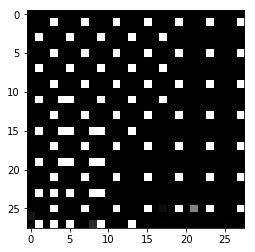

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94874257]]


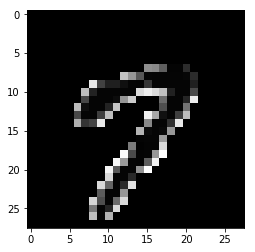

Epoch 1/1
40000/40000 [==============================] - 502s - loss: 15.3122   
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  5.14324070e-16]]


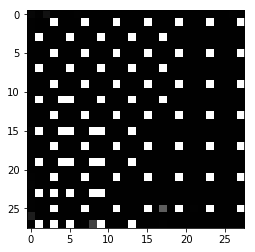

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94874257]]


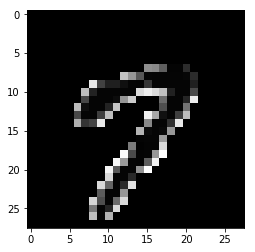

In [22]:
epochs = 1
k = 1   #discriminator trained k times, then generator trained once

for i in range(0,epochs):
    discriminator_training(gen,discrim,batch_size=64,epochs=k,latent_size=latent_size)
    plot_generated_real_img()
    
    generator_training(GAN,gen,discrim,batch_size=64,epochs=1,latent_size=latent_size)
    plot_generated_real_img()

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[  1.60487955e-16]]


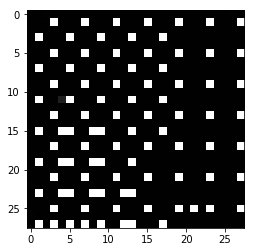

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94874257]]


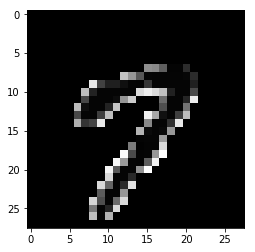

Epoch 1/1
29696/40000 [=====================>........] - ETA: 125s - loss: 15.3122

KeyboardInterrupt: 

In [23]:
epochs = 3
k = 0   #discriminator trained k times, then generator trained once

for i in range(0,epochs):
    discriminator_training(gen,discrim,batch_size=64,epochs=k,latent_size=latent_size)
    plot_generated_real_img()
    
    generator_training(GAN,gen,discrim,batch_size=128,epochs=1,latent_size=latent_size)
    plot_generated_real_img()